**Much of the code for solutions is in the `profit_curve_solution.py` script. We import it below as `ss` for solution script along with other necessary libraries for discussion of the sprint solutions in this notebook. Anywhere that the code from the solutions script does something worth discussing, that code will be put in a code block in this notebook, the block will not be runnable, the code will still be running from the import below. This way we can separate the implementation of code from the discussion of it.**

In [1]:
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import profit_curve_solution as ss
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path_input_data = './data/churn.csv'

## Part 1: Cost-Benefit Matrices


#### Create another cost-benefit matrix for the same scenario, but assuming that churning is the status quo and that sending a promotion to someone costs money but does prevent someone from churning.

#### Use this cost benefit matrix for the rest of the assignment. 

Note that this budget is highly pessimistic, so there should be a positive value if users don't churn and zero if they do (minus the cost of promotions).

|                        | Actual Positive | Actual Negative |
| ---------------------- |:---------------:|:---------------:|
| **Predicted Positive** |        6        |         6       |
| **Predicted Negative** |        0        |         9       |

## Part 2: Profit Curves
#### Cost-Benefit and Profit Curve Example
Say we ran a model and got the following results:

| Observation | True Label | Predicted Probability |
| ----------- | ---------- | --------------------- |
|       0     |      0     |          0.2          |
|       1     |      0     |          0.6          |
|       2     |      1     |          0.4          |


#### 1. Write out the confusion matrix for each of the possible thresholds. There should be 4 confusion matrices. 

For each of the tables below, the threshold is stated in the upper left corner. It divides the range [0, 1] into two parts:
      

<center> predicted probability < threshold, labeled negatives </center>

<center> predicted probability >= threshold, labeled positives.</center>

|    *Threshold: 1.0*    | Actual Positive | Actual Negative |
| ---------------------- |:---------------:|:---------------:|
| **Predicted Positive** |        0        |         0       |
| **Predicted Negative** |        1        |         2       |

|    *Threshold: 0.6*    | Actual Positive | Actual Negative |
| ---------------------- |:---------------:|:---------------:|
| **Predicted Positive** |        0        |         1       |
| **Predicted Negative** |        1        |         1       |

|    *Threshold: 0.4*    | Actual Positive | Actual Negative |
| ---------------------- |:---------------:|:---------------:|
| **Predicted Positive** |        1        |         1       |
| **Predicted Negative** |        0        |         1       |

|    *Threshold: 0.2*    | Actual Positive | Actual Negative |
| ---------------------- |:---------------:|:---------------:|
| **Predicted Positive** |        1        |         2       |
| **Predicted Negative** |        0        |         0       |


Notice how the sum of the **Actual Positive** and **Actual Negative** columns is always sum the to true label count from the first table: 2 negatives and 1 positive. Those counts just move between the **Preducted Positive** and **Predicted Negative** rows as we move the threshold.

#### 2. Calculate the profit for each of these confusion matrices.

Using the cost-benefit matrix we figured out in part 1, let's do this with some code:

In [3]:
cost_benefit = np.array([[6, 6], [0, 9]])
thresholds = [1.0, 0.6, 0.4, 0.2]
confusion_matrices = [np.array([[0, 0], [1, 2]]),
                      np.array([[0, 1], [1, 1]]),
                      np.array([[1, 1], [0, 1]]),
                      np.array([[1, 2], [0, 0]])]
total_observations = 3

for threshold, confusion_matrix in zip(thresholds, confusion_matrices):
    threshold_expected_profit = np.sum(cost_benefit * confusion_matrix) / total_observations
    print('Profit at threshold of {}: {}'.format(threshold, threshold_expected_profit))

Profit at threshold of 1.0: 6.0
Profit at threshold of 0.6: 5.0
Profit at threshold of 0.4: 7.0
Profit at threshold of 0.2: 6.0


<ul> <ul> The key to this is that we can use the `*` operator between two numpy arrays of the same size and numpy performs element-wise multiplicaiton, just what we want for profit curve calculation. Then we sum up all the values in the resulting 2x2 matrix and divide by the total number of observations to get the expected profit.

Notice how expressive the rest of the code is, we have no hard coded values outside of our variable declarations. This makes it easy to read those variable declarations and understand what ideas they represent, and easy to read the body of the for loop. Part of this is achieved with our clever use of the `izip()` function.

### Part 3: Profit Curve Implementation

#### 1. Clean up the churn dataset with pandas. You should be predicting the "Churn?" column. You can drop the "State", "Area Code" and "Phone" columns. Make sure to convert any yes/no columns to 1/0's. 

This must be done with code, it also makes sense to perform the cleaning actions in a function as it is performing a specific task that we can easily name and we might want to call that code in other places, the function is called `make_clean_churn_df()`. This will be useful later in the assignment.

In [4]:
dirty_churn_df = pd.read_csv(path_input_data)
clean_churn_df = ss.make_clean_churn_df(dirty_churn_df)

#### 2. Specify a cost-benefit matrix as a 2x2 `numpy` array. Each cell of the matrix will correspond to the corresponding cost/benefit of the outcome of a correct or incorrect classification. This matrix is domain specific, so choose something that makes sense for the churn problem. It should contain the cost of true positives, false positives, true negatives and false negatives in the following form:

```python
[[tp, fp]
 [fn, tn]]
```

 Here's where we can use some intuition to place some values on the cost of trying to identify a customer as a potential churner, and the benefit of doing so correctly. Without scrutinizing these numbers too highly let's say that if we predict a customer as someone who is likely to churn in the near future we might want to incentivize them to remain active by sending them a $20 off coupon.  


Now there are two options that could result from the campaign, they could stay a customer, in which case we continue to gain the profit associated with that, lets say it's \\$99, but they could also just use the coupon and then churn anyways. Remember, either way we're spending \\$20 with this plan. This leaves us with the following cost-benefit matrix:

```python
[[79, -20],
 [ 0,   0]]
```
We could fret over what happens when we don't predict that someone is going to churn and place values on the associated situations. But for now this cost-benefit matrix will do.

In [5]:
cost_benefit_matrix = np.array([[79, -20], [ 0,   0]])

#### 3. Since sklearn's confusion matrix function creates a flip-flopped confusion matrix, you will appreciate having your own that is ordered in the way you're familiar with.

#### Write a function `standard_confusion_matrix` which takes `y_true` and `y_predict` and returns the confusion matrix as a 2x2 numpy array of the form `[[tp, fp], [fn, tn]]`.

#### You may use sklearn's `confusion_matrix` function here, but having it in the standard form will reduce the amount of banging your head against the wall. 

To transform the sklearn version of a confusion matrix to one that is more intuitive for our use we could write some fancy loops or so some array transposition. However, this seems to be a case where those techniques are a bit heavy-handed considering that the confusion matrix only ever has 4 elements in it...


With this in mind we can use list unpacking to achieve our goals. (*Note: assumes confusion_matrix has been imported from sklearn.metrics*)
```python
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])
```
All we do here is directly state the format of the array that we know confusion_matrix is going to return to us, and name the variables within this 2 dimensional array in the order that we know sklearn assigns them. Once those variables have been bound we can make and return a new array with them in the order that we consider standard.

#### 4. Write a function `profit_curve` that takes these arguments:</h4>
  * `cost_benefit`: the cost-benefit matrix
  * `predicted_probs`: predicted probability for each datapoint (between 0 and 1)
  * `labels`: true labels for each data point (either 0 or 1)

```python
def profit_curve(cost_benefit, predicted_probs, labels):
    """Function to calculate list of profits based on supplied cost-benefit
    matrix and prediced probabilities of data points and thier true labels.

    Parameters
    ----------
    cost_benefit    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    predicted_probs : ndarray - 1D, predicted probability for each datapoint
                                    in labels, in range [0, 1]
    labels          : ndarray - 1D, true label of datapoints, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(labels))
    maybe_one = [] if 1 in predicted_probs else [1]
    thresholds = maybe_one + sorted(predicted_probs, reverse=True)
    profits = []
    for threshold in thresholds:
        y_predict = predicted_probs >= threshold
        confusion_matrix = standard_confusion_matrix(labels, y_predict)
        threshold_profit = np.sum(confusion_matrix * cost_benefit) / n_obs
        profits.append(threshold_profit)
    return np.array(profits), np.array(thresholds)

```
<ul> One fancy thing here. We don't know if `1` is going to be a value the predicted probabilities, it's unlikely, but possible. To account for this we use a ternary statement to make a list that we will always put at the beginning of our thresholds. We do this via list concatenation which we know will always work since `sorted()` always returns a list. It will be empty if a `1` is already in the predicted probabilities, or a singleton list with the value `1` in it otherwise.

One other thing to notice. We sort the predicted probilites in reverse order up front and store the resulting list, plus the `maybe_one`, as `thresholds`. There's nothing inherently clever about this, but it does make the code in the rest of the function more readable. Notice how the for loop and it's body gets close to reading like english.

#### 5. Test your `profit_curve` function on the same toy example from above.</h4>  

See below, we get the exact same results as above!

Note how the results of `profit_curve()` are stored to a single variable even though we know that it returns two values. We can see that this result is a tuple of the things we expect when we print it. In addition, we can see that the `*` at the beginning of `profit_curve_results`, when its passed to `izip()` is performing tuple unpacking. Try taking that `*` away and see what error Python throws. Why does this error make sense? It's also worth noting that this method of variable storage isn't always advisable since it obscures what `profit_curve()` is passing back into a single varaible. Here we're using it so we can look at the type of both the values that are passed back with a single print statement and to demonstrate some tuple unpacking.

Feel free to play with excluding the `maybe_one`, along with varying whether or not a `1` is in the predicted probabilities. Do you think it's worth having `maybe_one` in the function?

In [6]:
test_cost_benefit = np.array([[6, 6], [0, 9]])
test_probs = np.array([0.2, 0.6, 0.4])
test_labels = np.array([0, 0, 1])

profit_curve_results = ss.profit_curve(test_cost_benefit, test_probs, test_labels)
print(profit_curve_results)
for profit, threshold in zip(*profit_curve_results):
    print('Profit at threshold of {}: {}'.format(threshold, profit))

(array([6., 5., 7., 6.]), array([1. , 0.6, 0.4, 0.2]))
Profit at threshold of 1.0: 6.0
Profit at threshold of 0.6: 5.0
Profit at threshold of 0.4: 7.0
Profit at threshold of 0.2: 6.0


## Part 4: Profit Curve Investigation & Part 5: Optimization

#### 1. Write `plot_profit_curve()` function. 

#### 2. Use `plot_profit_curve()` to compare models.   

#### 3. Find maximum profit. 
     
The code that answers the questions in this part is on lines 114-221 in the solution script. It has been refactored to address the question raised in Part 5: Optimization (are there any unnecessary computations taking place in your code?). If we were to calculate the profits and thresholds for each model when we go to plot the profit curves **AND** when we go to determine the best model-threshold combination, then we do all the profit calculations **twice**. Not ideal.

To get around the need to do this twice, we replaced the `plot_profit_curve()` with a new function, `get_model_profits()`. This function will take a model objecs, a cost-benefit matrix and training and testing data and train the model on the training data then run `profit_curve()` on the test data.

Take a look at `profit_curve_main()` and you can see how `get_model_profits()` is useful. We loop over whatever models we're interested in testing, and pass each to `get_model_profits()` getting back the profits and thresholds associated with each. We then immediately put those and the model into a tuple and append that to a master `model_profits` list.

One interesting question we could ask is if a list of tuples is the best way we can store this information? The other potential possibility is a dictionary. Wouldn't that make sense, you have a model, key, and it's associated profits and thresholds, value. However, if you stop to think about the implications of a dictionary like this you'll realize that it makes no sense to have a model as a key to a dictionary since you would need the actual model to index into the dictionary (why sklearn models are hashable is another question...and they are, if you're wondering).

With the `model_profits` list, calculated upfront and once, we can plot all of the associated profit curves and find the best model-threshold combination by making functions for each of these tasks that take in the model_profits list; in the solutions script they're called `plot_model_profits()` and `find_best_threshold()` respectively.

Now we can see the benefits of having our code be modularized and posessing a natural starting in the `profit_curve_main()`. Let's test that function out here using the cost-benefit matrix we defined in an earlier cell.

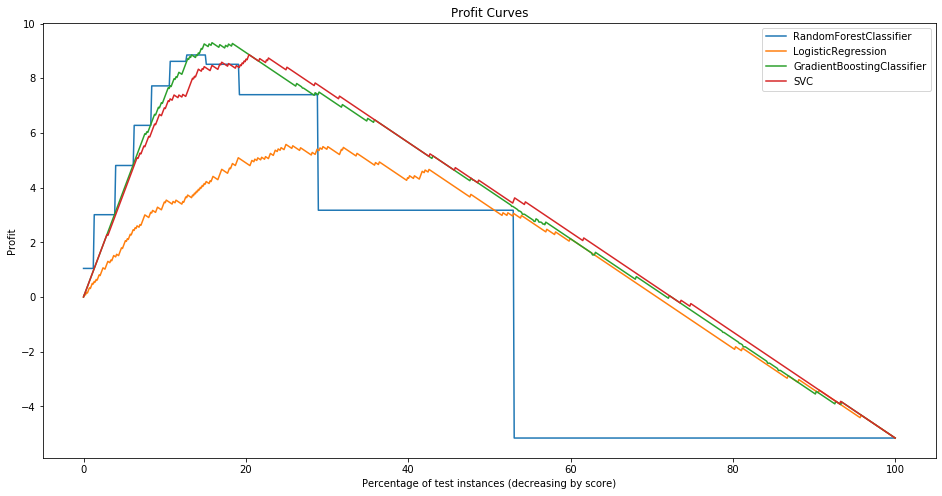

Best model:		GradientBoostingClassifier
Best threshold:		0.22
Resulting profit:	9.298561151079136
Proportion positives:	0.54


In [7]:
np.random.seed(42)
plt.figure(figsize=(16, 8))
ss.profit_curve_main(path_input_data, cost_benefit_matrix)

## Part 6: Sampling Methods
#### Frequently we will to classify on datasets that do not have each class proportionally represented. You're aware of three main ways to counteract some of the negative effects class imbalance can cause on your models. Now you need to implement them below.

#### Throughout the rest of this part you will need to fill out a sampling method function according to its doc string. Some notes on coding approach are there for guidance. In addition, take a look at the [`numpy.random`](https://docs.scipy.org/doc/numpy/reference/routines.random.html) module, it will be very useful of the randomization tasks you'll need to perform in these functions.

One thing that the solutions do which aren't directed in the sprint is to make a function to split up the positive and negative observations in X & y and return the count of each. In the solution script this function is called **`div_count_pos_neg()`** and it is called in each of the sampling functions.

As mentioned in the sprint, all of the following functions make heavy use of the `numpy.random` module, in particular the [`choice()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html#numpy.random.choice) and [`randint()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html#numpy.random.randint) functions.

### Undersampling

```python
def undersample(X, y, tp):
    """Randomly discards negative observations from X & y to achieve the
    target proportion of positive to negative observations.

    Parameters
    ----------
    X  : ndarray - 2D
    y  : ndarray - 1D
    tp : float - range [0, 1], target proportion of positive class observations

    Returns
    -------
    X_undersampled : ndarray - 2D
    y_undersampled : ndarray - 1D
    """
    if tp < np.mean(y):
        return X, y
    neg_count, pos_count, X_pos, X_neg, y_pos, y_neg = div_count_pos_neg(X, y)
    negative_sample_rate = (pos_count * (1 - tp)) / (neg_count * tp)
    negative_keepers = np.random.choice(a=[False, True], size=neg_count,
                                        p=[1 - negative_sample_rate,
                                           negative_sample_rate])
    X_negative_undersampled = X_neg[negative_keepers]
    y_negative_undersampled = y_neg[negative_keepers]
    X_undersampled = np.vstack((X_negative_undersampled, X_pos))
    y_undersampled = np.concatenate((y_negative_undersampled, y_pos))

    return X_undersampled, y_undersampled
```
Here we want to randomly choose some of the negative observations to keep and discard the rest. We already have the negative examples from `div_count_pos_neg()`, so all we need is a way to select a subset of the negative observations for retention. As stated above, the `choice()` function allows us to specify a rate at which elemets are chosen.

So we can make a boolean index for the negative observations by choosing from `[False, True]` at a rate appropriate to achieve the target proportion, `tp`, number of negative observations times. This is boolean index is bound to `negative_keepers` and then used to index into the negative arrays produced by `div_count_pos_neg()`.

As for the `negative_sample_rate` we can get that by solving the following equation for `negative_sample_rate`.

$$ tp = \frac{pos\_count}{(neg\_count \times negative\_sample\_rate) + pos\_count)} $$

Note: the resulting equation won't work if our target proportion is less than the ratio of positives to negative observations. This is why we have the `if` statement as the first line in the function that we do. In addition, since numpy is sampling from `[False, True]` with the specified proportion, we aren't *guaranteed* to get the exact target proportion we're looking for. But, in general, especially with large datasets, it will be close enough.

### Oversampling

```python
def oversample(X, y, tp):
    """Randomly choose positive observations from X & y, with replacement
    to achieve the target proportion of positive to negative observations.

    Parameters
    ----------
    X  : ndarray - 2D
    y  : ndarray - 1D
    tp : float - range [0, 1], target proportion of positive class observations

    Returns
    -------
    X_undersampled : ndarray - 2D
    y_undersampled : ndarray - 1D
    """
    if tp < np.mean(y):
        return X, y
    neg_count, pos_count, X_pos, X_neg, y_pos, y_neg = div_count_pos_neg(X, y)
    positive_range = np.arange(pos_count)
    positive_size = (tp * neg_count) / (1 - tp)
    positive_idxs = np.random.choice(a=positive_range,
                                     size=int(positive_size),
                                     replace=True)
    X_positive_oversampled = X_pos[positive_idxs]
    y_positive_oversampled = y_pos[positive_idxs]
    X_oversampled = np.vstack((X_positive_oversampled, X_neg))
    y_oversampled = np.concatenate((y_positive_oversampled, y_neg))

    return X_oversampled, y_oversampled
```
Here, again we make use of `div_count_pos_neg()` and of the `choice()` function. This time, though, we are oversampling which means we need to choose from the existing positive observations with replacement. Luckily the `choice()` function has a `replace` parameter, so we set it to `True`.

What, then, are we choosing from? You can see that it is just the range from `0` to `pos_count - 1`, this makes sense because what these values will actually correspond to are indices. So when we choose with replacement we get `positive_idxs` which is a 1 dimensional numpy array whoes elements correspond with indices in the `*_pos` arrays. We then index into those positive arrays with the likely repeated indices to get our oversampled population.

We can find the equation for `positive_size` similarly as we found it for `negative_sample_rate` above, this time by solving the following equation for `positive_size`.

$$ tp = \frac{positive\_size}{positve\_size + neg\_count} $$

### SMOTE - Synthetic Minority Oversampling TEchnique

<h4> SMOTE is a method to randomly generate new minority class observations according to following procedure:  </h4>

1. For each observation in the minority class, find the k nearest neighbors.
2. Randomly select both an observation and one of its k nearest neighbors.
3. Generate a new synthetic observation from these two points via:  
        1) Find the vector between the observation and its neighbor.
        2) Add randomness to this vector by walking a random percentage along each of its dimensions.
        3) Add this new vector to the original observation to make the synthetic observation.
        4) Label this synthetic observation as a member of the minority class (i.e. `y = 1`)

```python
def smote(X, y, tp, k=None):
    """Generates new observations from the positive (minority) class.
    For details, see: https://www.jair.org/media/953/live-953-2037-jair.pdf


    Parameters
    ----------
    X  : ndarray - 2D
    y  : ndarray - 1D
    tp : float - [0, 1], target proportion of positive class observations

    Returns
    -------
    X_smoted : ndarray - 2D
    y_smoted : ndarray - 1D
    """
    if tp < np.mean(y):
        return X, y
    if k is None:
        k = int(len(X) ** 0.5)

    neg_count, pos_count, X_pos, X_neg, y_pos, y_neg = div_count_pos_neg(X, y)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pos, y_pos)
    neighbors = knn.kneighbors(return_distance=False)

    positive_size = (tp * neg_count) / (1 - tp)
    smote_num = int(positive_size - pos_count)

    rand_idxs = np.random.randint(0, pos_count, size=smote_num)
    rand_nghb_idxs = np.random.randint(0, k, size=smote_num)
    rand_pcts = np.random.random((smote_num, X.shape[1]))
    smotes = []
    for r_idx, r_nghb_idx, r_pct in izip(rand_idxs, rand_nghb_idxs, rand_pcts):
        rand_pos, rand_pos_neighbors = X_pos[r_idx], neighbors[r_idx]
        rand_pos_neighbor = X_pos[rand_pos_neighbors[r_nghb_idx]]
        rand_dir = rand_pos_neighbor - rand_pos
        rand_change = rand_dir * r_pct
        smoted_point = rand_pos + rand_change
        smotes.append(smoted_point)

    X_smoted = np.vstack((X, np.array(smotes)))
    y_smoted = np.concatenate((y, np.ones((smote_num,))))
    return X_smoted, y_smoted
```

There are two parts to this solution that deserve to be talked about. Getting the nearest neighbor list and making new synthetic observations.

1. **Getting the nearest neighbor list**:

  Here we used sklearn's kNN classifier to do a lot of heavy lifting for us. For each observation we want a list of the observations that are closest to that observation via euclidean distance. We could compute this ourselves with numpy's `pdist()` function; however the closest observation to each observation we'd get from that method will always the same observation, and removing them would be a pain. Since it costs nothing to "fit" a kNN model we can take advantage of it's `.kneighbors()` method which automatically removes the observation we noted would be a problem. Take a look at the sklearn docs for more info on this.  

     
2. **Making a synthentic observation**:

  We need three things to make a synthetic observation:
  
          1) A random observation from the minority class.
          2) A random minority neighbor of the first random observation.
          3) A random percentage of the distance to walk in each of the dimensions along the vector between
             the first observation and the second.
  
  To make our looping more efficient and our code more expressive we create np.arrays for each of these things upfront of the necessary size to achieve the desired minority-majority proportion (see `oversampling()` for a discussion of getting this num, here `positive_size` is the same as it was in `oversampling()` and `smote_num` is the number beyond the number of existing positive observations necessary to get to `positive_size`.
  
  Let's see what each of these arrays do:
  
          1) rand_idxs, 1D array of random integers, 0 - pos_count, used to index into positives to get first
             random point.
          2) rand_nghb_idxs, 1D array of random integers, 0 - k (number of neighbors), used to index into the
             neighbors list retrieved from the kNN model.
          3) rand_pcts, 2D array of floats, 0 - 1. These will be used to multiply, element-wise, by the vector
             between the first two random points to get a vector to add on to the first random point.
             
  Once we have these three arrays we can zip them together and loop over their associated triples. For each iteration in the loop we:
      
          1) Index into the appropriate arrays to get the random points, rand_pos and rand_pos_neighbor.
          2) Find the vector pointing from rand_pos to rand_pos_neighbor, rand_dir.
          3) Multiply, element-wise, this random_dir by the random percentages, r_pct, to get a vector to
             add to rand_pos, rand_change.
          4) Add rand_change to rand_pos, again element-wise, and append the result to the smotes list.
          
The solutions also contain a `sampling_main()` function to test out the sampling code. Let's run it a couple of times below so we can answer the next sections questions.

In [8]:
ss.sampling_main(LR(), path_input_data, cost_benefit_matrix)

Profit from original ratio:
	0.15 ->	1.81894
Profit when undersampling to ratio of:
	0.35 ->	4.26259
	0.40 ->	4.11391
	0.45 ->	4.33933
	0.50 ->	4.06835
	0.55 ->	3.36930
	0.60 ->	2.90408
	0.65 ->	2.32854
Profit when oversampling to ratio of:
	0.35 ->	4.16787
	0.40 ->	4.11151
	0.45 ->	4.45923
	0.50 ->	4.09592
	0.55 ->	3.56475
	0.60 ->	3.83933
	0.65 ->	2.82974
Profit when smoting to ratio of:
	0.35 ->	4.26139
	0.40 ->	4.34652
	0.45 ->	4.15108
	0.50 ->	4.11871
	0.55 ->	3.61271
	0.60 ->	3.43885
	0.65 ->	3.26499


In [9]:
ss.sampling_main(LR(), path_input_data, cost_benefit_matrix)

Profit from original ratio:
	0.15 ->	2.31535
Profit when undersampling to ratio of:
	0.35 ->	5.13549
	0.40 ->	5.10192
	0.45 ->	4.70863
	0.50 ->	4.93765
	0.55 ->	4.48441
	0.60 ->	3.49281
	0.65 ->	3.06235
Profit when oversampling to ratio of:
	0.35 ->	4.96643
	0.40 ->	5.38729
	0.45 ->	4.92686
	0.50 ->	5.13429
	0.55 ->	4.55396
	0.60 ->	4.09472
	0.65 ->	3.08513
Profit when smoting to ratio of:
	0.35 ->	5.03717
	0.40 ->	5.07554
	0.45 ->	4.80815
	0.50 ->	5.01439
	0.55 ->	4.46043
	0.60 ->	3.80935
	0.65 ->	3.44604


In [10]:
ss.sampling_main(LR(), path_input_data, cost_benefit_matrix)

Profit from original ratio:
	0.15 ->	1.74221
Profit when undersampling to ratio of:
	0.35 ->	3.32974
	0.40 ->	3.84412
	0.45 ->	3.33933
	0.50 ->	3.37770
	0.55 ->	2.89568
	0.60 ->	2.36571
	0.65 ->	1.54317
Profit when oversampling to ratio of:
	0.35 ->	3.80456
	0.40 ->	3.82014
	0.45 ->	3.67026
	0.50 ->	3.78177
	0.55 ->	3.27698
	0.60 ->	2.79137
	0.65 ->	2.13909
Profit when smoting to ratio of:
	0.35 ->	3.54077
	0.40 ->	3.60552
	0.45 ->	3.43405
	0.50 ->	3.21463
	0.55 ->	3.30096
	0.60 ->	2.77098
	0.65 ->	2.68945


We can see that there is some variance, but generally the best sampling ratio appears to be between 0.4 and 0.5. The variance originates from the issues arising from performing a simple train-test-split for validation. The best way we could address the variance problem is by using k-fold cross validation to compute an average expected profit across all folds using each sampling method at a finer range of sampling ratios.